# EOF Analysis of AR days

* Multivariate EOF analysis in T-mode
* K-means clustering

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/repositories/sallj-types/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### SALLJ time series

In [4]:
# Read CSV data into pandas DataFrame
filepath = path_to_data + 'erai.llj.day.1979-2016.csv'
df = pd.read_csv(filepath)

# Add datetime column
df['dates'] = pd.date_range(start='1979-01-01',end='2016-12-31',freq='D')
# Set the index to `dates`
df.set_index('dates', inplace=True)

# Add column of LLJ days (no LLJ day eq 0; LLJ day eq 1)
df['llj'] = 0
idx = (df['llj_sc'] > 0) | (df['llj_ma'] > 0)
df.loc[idx, 'llj'] = 1

# Add column of LLJ locations ('SC', 'MA', 'SC/MA', nan)
df['location'] = np.nan

idx = (df['llj_sc'] == 1) & (df['llj_ma'] == 0)
df.loc[idx, 'location'] = 'SC'

idx = (df['llj_sc'] == 0) & (df['llj_ma'] == 1)
df.loc[idx, 'location'] = 'MA'

idx = (df['llj_sc'] == 1) & (df['llj_ma'] == 1)
df.loc[idx, 'location'] = 'SC/MA'

# Show table
df.head()


,year,mon,day,llj_sc,llj_ma,llj,location
dates,,,,,,,
1979-01-01,1979,1,1,1,0,1,SC
1979-01-02,1979,1,2,1,0,1,SC
1979-01-03,1979,1,3,0,0,0,NaN
1979-01-04,1979,1,4,0,0,0,NaN
1979-01-05,1979,1,5,0,0,0,NaN


### ERA5 reanalysis

In [5]:
## Set variable names (for saving data/figs)
var_names = 'SAM-IVT'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid
lonmin = -165
lonmax = -12
latmin = -60
latmax =  20

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat


### ERA5 DATA ###
# Read datafiles into xarray datasets
f1 = xr.open_dataset(path_to_data+'era5.sam.05dg.ivte.1979-2016.nc')
f2 = xr.open_dataset(path_to_data+'era5.sam.05dg.ivtn.1979-2016.nc')

# # Merge variables into one dataset
# era = xr.merge([f1,f2])

# Create new dataset to rename lat lon
era = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1.ivte.values),
                  'ivtn': (['time', 'lat', 'lon'], f2.ivtn.values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

In [6]:
# Add LLJ time series to era5; set as coordinate variables
era['llj'] = ('time', df.llj)
era = era.set_coords('llj')

era['location'] = ('time', df.location)
era = era.set_coords('location')

# print dataset
print(era)

<xarray.Dataset>
Dimensions:   (lat: 131, lon: 111, time: 13880)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lat       (lat) float32 15.0 14.5 14.0 13.5 13.0 ... -48.5 -49.0 -49.5 -50.0
  * lon       (lon) float32 -85.0 -84.5 -84.0 -83.5 ... -31.5 -31.0 -30.5 -30.0
    llj       (time) int64 1 1 0 0 0 0 0 0 0 0 0 1 1 ... 0 0 1 1 1 1 1 1 0 0 1 1
    location  (time) object 'SC' 'SC' nan nan nan ... nan nan 'MA' 'SC/MA'
Data variables:
    ivte      (time, lat, lon) float64 -217.4 -253.5 -285.8 ... 103.8 100.8
    ivtn      (time, lat, lon) float64 12.83 10.75 9.769 ... 33.75 33.99 38.06


### Data Subset Selection

In [7]:
# Trim date range
start_date = '1979-11-01'
end_date = '2016-03-31'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select NDJFM months
idx = (era.time.dt.month >= 11) | (era.time.dt.month <= 3)
era = era.sel(time=idx)

# Select lat/lon grid
lonmin = -83
lonmax = -32
latmin = -47
latmax =  10
era = era.sel(lon=slice(lonmin,lonmax), lat=slice(latmax,latmin))

# Select LLJ days
idx = (era.llj >= 1)
era_llj = era.sel(time=idx)

# print results
print(era_llj)

<xarray.Dataset>
Dimensions:   (lat: 115, lon: 103, time: 1765)
Coordinates:
  * time      (time) datetime64[ns] 1979-11-07T09:00:00 ... 2016-03-18T09:00:00
  * lat       (lat) float32 10.0 9.5 9.0 8.5 8.0 ... -45.5 -46.0 -46.5 -47.0
  * lon       (lon) float32 -83.0 -82.5 -82.0 -81.5 ... -33.5 -33.0 -32.5 -32.0
    llj       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'SC/MA' 'SC/MA' 'SC/MA' ... 'SC/MA' 'MA' 'MA'
Data variables:
    ivte      (time, lat, lon) float64 22.23 30.74 12.73 ... 15.8 15.23 14.65
    ivtn      (time, lat, lon) float64 -164.1 -188.1 -180.7 ... -53.52 -50.42


In [8]:
# Count number of independent AR events

years = np.arange(1979, 2017) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single NDJFM season
    date1 = "{}-11-01".format(years[k])
    date2 = "{}-03-31".format(years[k+1])
    x = era.llj.sel(time=slice(date1,date2)).values
    # Count LLJ events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent LLJ events: ", total_events)

Number of independent LLJ events:  677


In [9]:
# Mean IVT of LLJ days in NDJFM
era_llj_clim = era_llj.mean(dim='time')
#print(era_llj_clim, '\n')

# IVT Anomalies
era_llj['ivte_anom'] = era_llj.ivte - era_llj_clim.ivte
era_llj['ivtn_anom'] = era_llj.ivtn - era_llj_clim.ivtn
#print(era_llj)

## Preprocessing

### Reshape, center, and standardize data matrix

In [13]:
var1 = era_llj.ivte_anom
var2 = era_llj.ivtn_anom

var_list = [var1, var2]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)

(1765, 115, 103)
(1765, 115, 103)


In [14]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data 
var_list = flatten_array(var_list)


CPU times: user 314 ms, sys: 322 ms, total: 636 ms
Wall time: 632 ms


In [12]:
## Remove nans
## outputs two lists of arrays
## one without nans removed, and one with nans removed
var_list, var_list_nan = remove_nans(var_list)

print('Size of array with missing data removed: ', var_list_nan[0].shape)
print('Size of array without missing data removed: ', var_list[0].shape)

NameError: name 'X_da_nan' is not defined

In [ ]:
# ntim, npts = var_list[0].shape

# tmp1 = var_list[0]
# tmp2 = var_list[1]
# # Transpose arrays to get [space x time]
# X1 = tmp1.T
# X2 = tmp2.T

# # Center and standardize by columns
# x1mean = np.mean(X1, axis=0)
# x1std = np.std(X1, axis=0)
# X1s = (X1-x1mean) / x1std

# x2mean = np.mean(X2, axis=0)
# x2std = np.std(X2, axis=0)
# X2s = (X2-x2mean) / x2std

# # Combine variables into single data matrix Xs
# Xs = np.empty((nvar*npts,ntim))
# Xs[0:npts,:] = X1s
# Xs[npts:,:]  = X2s
# print(Xs.shape)

# # Check that column means=0 and std dev=1
# test = np.mean(np.mean(Xs, axis=0))
# print("Column means: ", np.round(test,2))
# test = np.mean(np.std(Xs, axis=0))
# print("Column std: ", np.round(test,2))

In [15]:
## Standardize and put into single data matrix
## Array without missing values removed
Xs = standardize_arrays_new(var_list, mode=eofmode, dispersion_matrix=dispmat)

# ## Array with missing values removed
# Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  t
Dispersion Matrix:  cor
(23690, 1765)
Column means:  -0.0
Column std:  1.0


## EOF Analysis

In [16]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eofs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (1765,)
[2.26275176e+02 1.97722056e+02 1.50885537e+02 ... 3.20618978e-03
 3.21207720e-03 3.20883822e-03] 

Eigenvectors:  (1765, 1765)
[[-0.011  0.032 -0.034 ...  0.009 -0.007  0.043]
 [ 0.044  0.018 -0.01  ... -0.008  0.01   0.016]
 [ 0.024 -0.003 -0.    ...  0.005 -0.03   0.022]
 ...
 [ 0.047  0.035  0.004 ... -0.015  0.018 -0.021]
 [-0.043  0.001  0.012 ...  0.034 -0.054  0.043]
 [-0.034  0.019 -0.007 ...  0.015  0.034  0.023]] 

CPU times: user 9min 49s, sys: 1min 24s, total: 11min 13s
Wall time: 15 s


Text(0.5, 1.0, 'Dispersion Matrix (cor)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


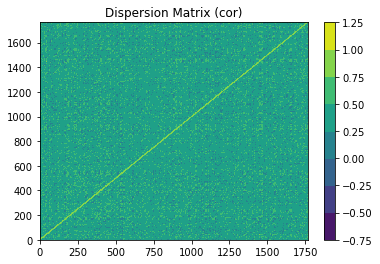

In [17]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [18]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 20 EOFs:
73.19% 

Cumulative variance explained by the first 4 EOFs:
32.57% 

1 	 12.82%
2 	 11.20%
3 	 8.55%
4 	 5.48%


### North Test

In [19]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[13.516 11.811  9.013  5.773  4.736  4.394]
[12.82  11.202  8.548  5.475  4.492  4.168]
[12.123 10.593  8.084  5.178  4.248  3.941]


### Fig 2: Variance

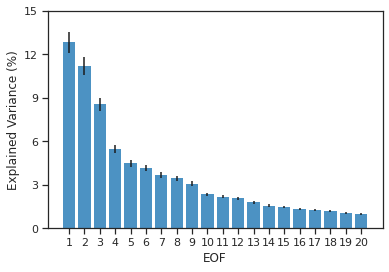

In [20]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [21]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(1765, 19)
[[-0.168  0.455 -0.423 ...  0.042  0.229  0.091]
 [ 0.657  0.249 -0.118 ... -0.081  0.11   0.031]
 [ 0.355 -0.042 -0.002 ...  0.036  0.068 -0.052]
 ...
 [ 0.702  0.497  0.053 ...  0.036  0.014 -0.13 ]
 [-0.643  0.015  0.148 ...  0.055 -0.11   0.046]
 [-0.513  0.274 -0.086 ... -0.018 -0.123 -0.039]]


### Save EOFs

In [22]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [23]:
# Calculate principal components (spatial modes)
neofs = 19
pcs = calc_pcs(Xs, evecs, neofs, mode=eofmode)

In [24]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var2.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [25]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting
lons = era.lon.data
lats = era.lat.data
udat = pcmodes[0][0:neofs,:,:]
vdat = pcmodes[1][0:neofs,:,:]
data = np.sqrt(udat**2 + vdat**2)
# data = vdat**2
print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

0.061978359292861676 70.0577364661655


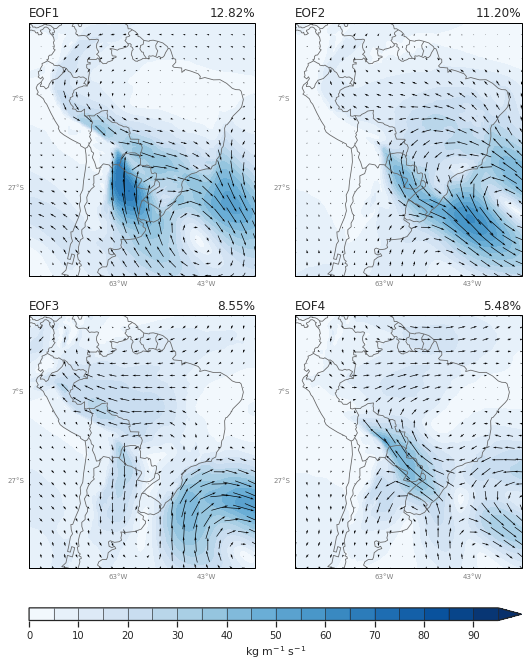

In [26]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Add contour fill plot
    clevs = np.arange(0,100,5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="Blues", extend='max')
    # add vectors
    ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=20)      
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('kg m$^{-1}$ s$^{-1}$', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

/home/nash/DATA/repositories/AR_types/figs/pc_SAM-IVTt-165-12-6020cor.png


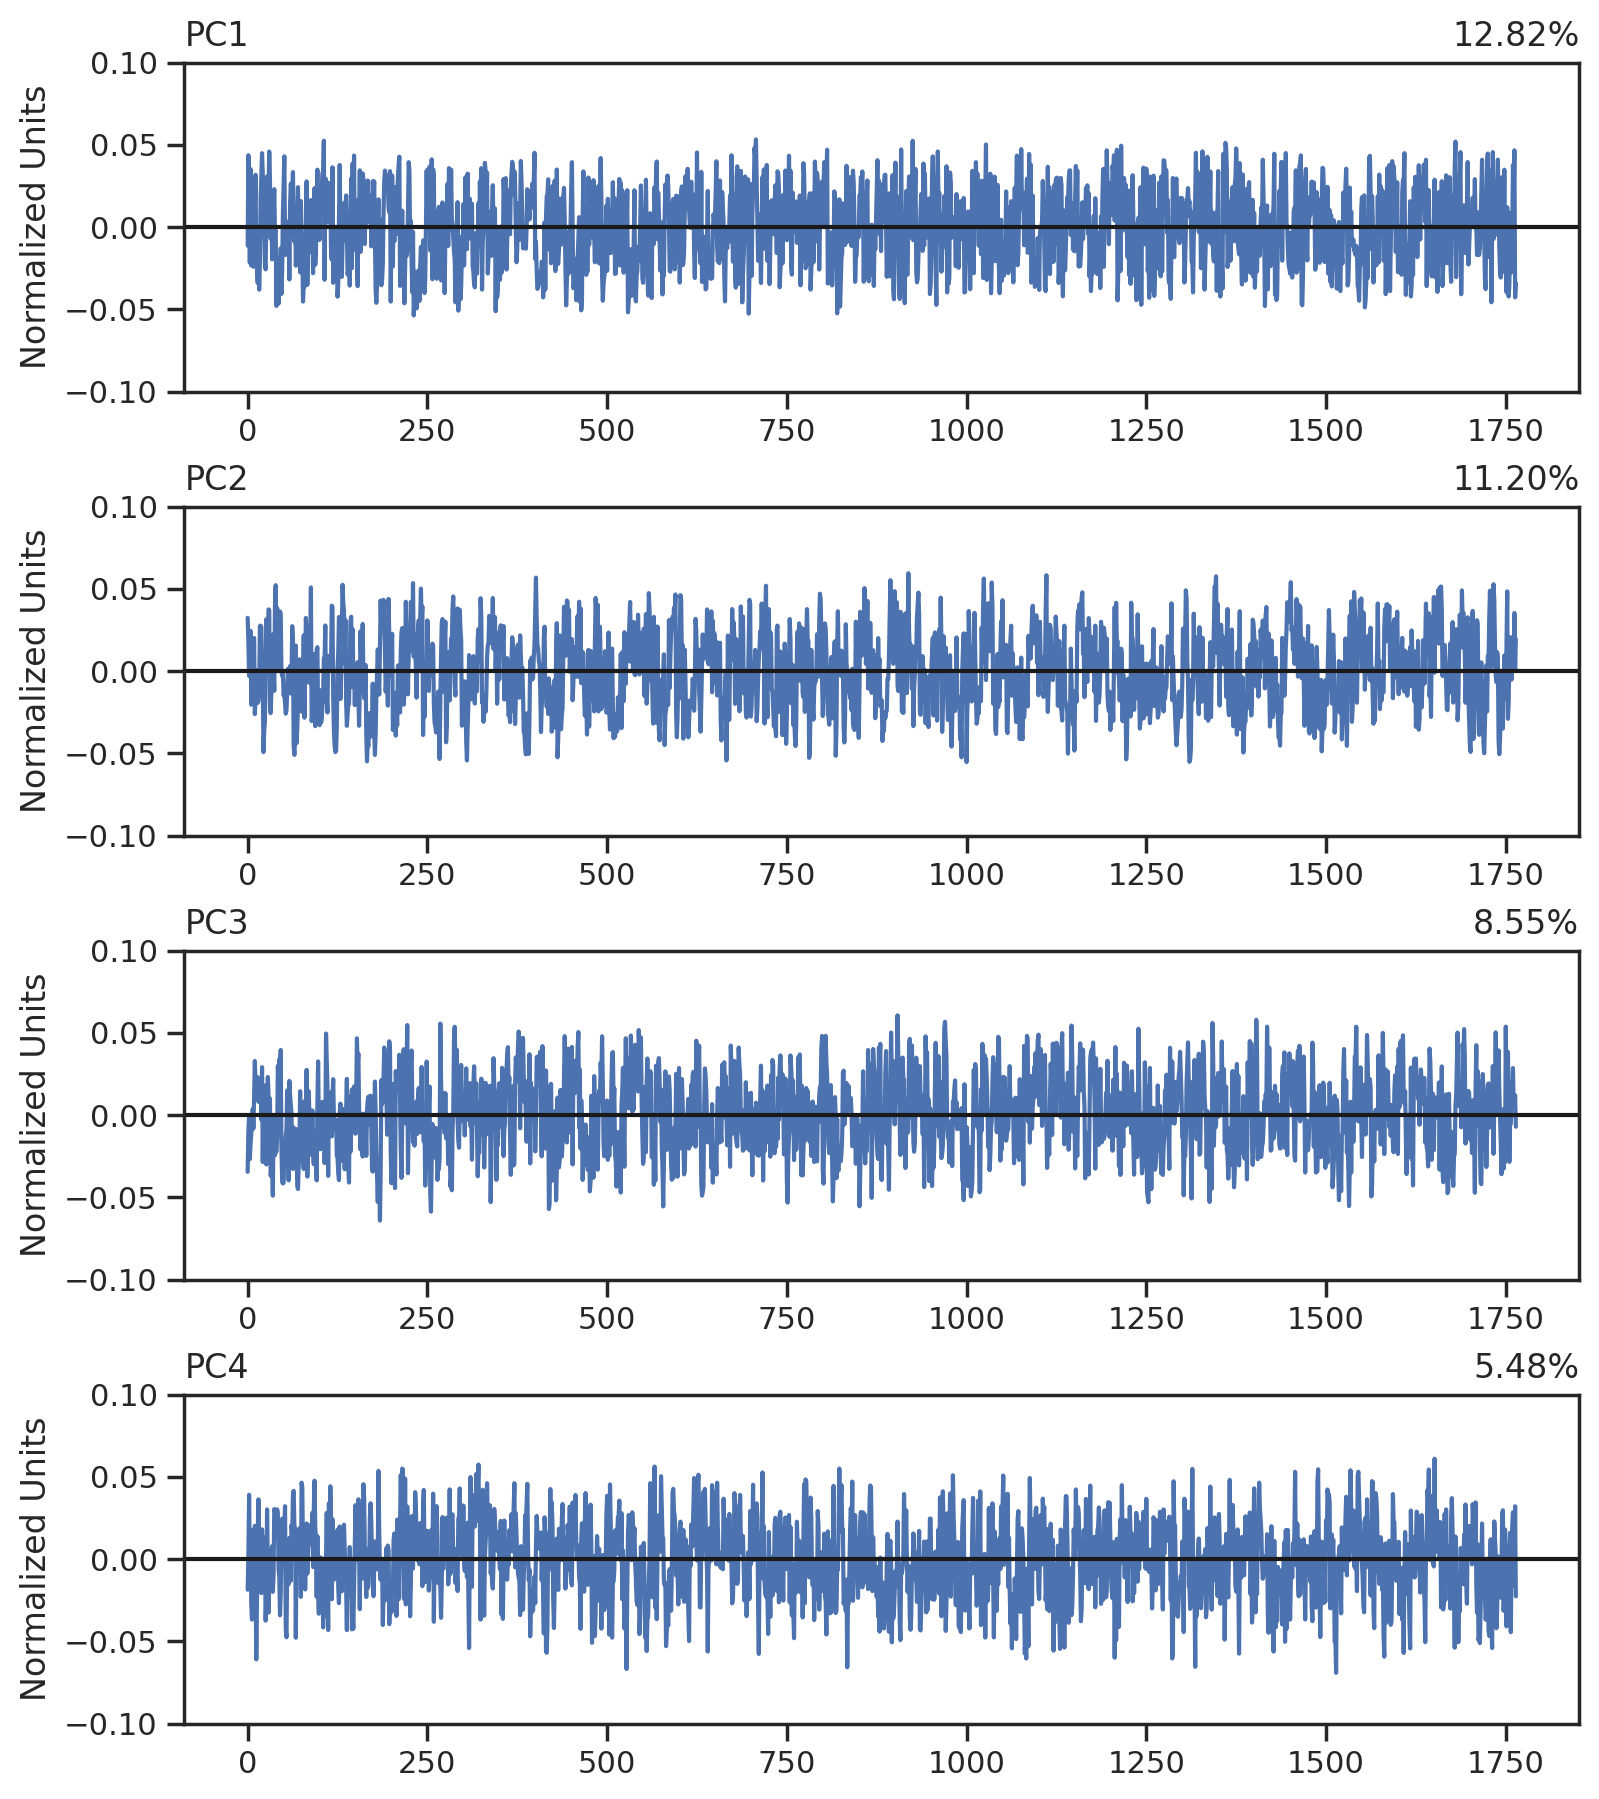

<Figure size 1800x2200 with 0 Axes>

In [27]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 200
fname = path_to_figs + 'pc_'+ fname_id
fmt = 'png'
results = evecs[:,:4]

X, nplots = results.shape
x = np.arange(len(results))

for i in np.arange(nplots):
    ax = plt.subplot(4, 1, i+1)
    ax.plot(x, results[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-0.1, 0.1)
    ax.set_ylabel('Normalized Units')
    # subtitles
    ax.set_title(pc_label[i], loc='left', fontsize=12)
    ax.set_title(var_label[i], loc='right', fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))